# Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook

import numpy as np
from tqdm.notebook import tqdm as tqdm
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]
import pandas as pd
import PIL

import shapely
import slide, filter, util, tiles
from shared.roi import RegionOfInterestPolygon


base_path = Path('/home/Deep_Learner/shared/Datasets/Hypophysenadenome/')
wsis_path = base_path/'wsis_experimenting'
rois_path = base_path/'rois_experimenting'
tiles_path = base_path/'tiles_experimenting'
wsis_path.mkdir(exist_ok=True)
tiles_path.mkdir(exist_ok=True)

# WSIs

## Process one WSI

In [ ]:
#TODO

In [ ]:
p = wsis_path.ls()[0];p

In [64]:
wsi = slide.open_slide(p)

In [65]:
wsi.dimensions

(39424, 26880)

In [62]:
arr = np.array([[0,0],[0, 39424],[39424,26880],[0, 26880]])

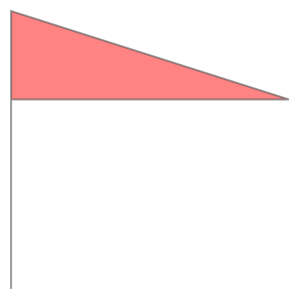

In [66]:
shapely.geometry.Polygon(arr)

In [ ]:

ts = tiles.WsiOrROIToTiles(wsi_path=p, 
                      tiles_folder_path=None, 
                      tile_height=256,
                      tile_width=256,
                      minimal_acceptable_tile_height=0.7,
                      minimal_acceptable_tile_width=0.7,
                      save_tiles=False, 
                      tile_score_thresh = 0.2, 
                      return_as_tilesummary_object=True, 
                      verbose=True)

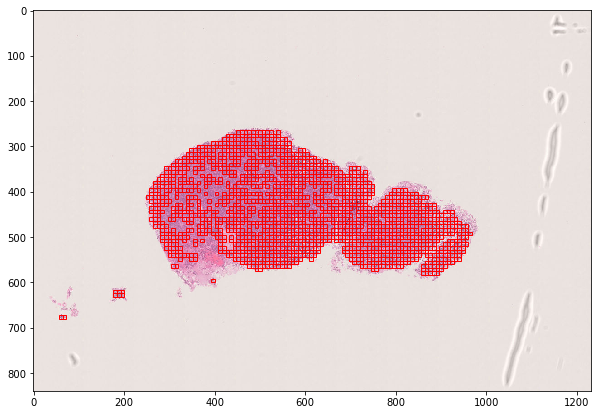

In [4]:
ts.show_wsi_with_marked_tiles()

In [9]:
tile = ts.top_tiles()[150]

In [12]:
tile


wsi: 1422-10-IV-HE.ndpi; [Tile #10380, Row #68, Column #62, Tissue 98.44%, Score 0.4865]

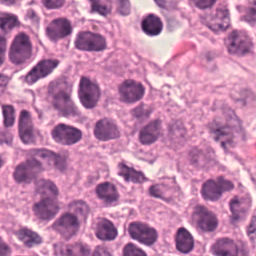

In [14]:
tile.get_pil_image()

## Process multiple WSIs in parallel

In [38]:
ts_list = tiles.WsiOrROIToTilesMultithreaded(wsi_paths=wsis_path.ls()[:2], 
                                       tiles_folder_path=None, 
                                   tile_height=256, 
                                   tile_width=256,
                                   minimal_acceptable_tile_height=0.7,
                                   minimal_acceptable_tile_width=0.7,
                                   save_tiles=False,
                                   tile_score_thresh = 0.2,
                                   return_as_tilesummary_object=True, 
                                   verbose=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Starting to process /home/Deep_Learner/shared/Datasets/Hypophysenadenome/wsis_experimenting/1422-10-IV-HE.ndpi
Starting to process /home/Deep_Learner/shared/Datasets/Hypophysenadenome/wsis_experimenting/125-15-II-HE.ndpi
/home/Deep_Learner/shared/Datasets/Hypophysenadenome/wsis_experimenting/1422-10-IV-HE.ndpi: Number of tiles that will be kept/all possible tiles: 1692/16170


 50%|█████     | 1/2 [00:06<00:06,  6.56s/it]

/home/Deep_Learner/shared/Datasets/Hypophysenadenome/wsis_experimenting/125-15-II-HE.ndpi: Number of tiles that will be kept/all possible tiles: 1127/26754


100%|██████████| 2/2 [00:10<00:00,  5.63s/it]

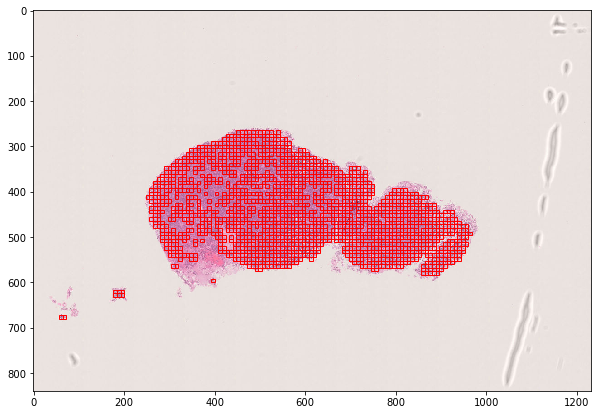

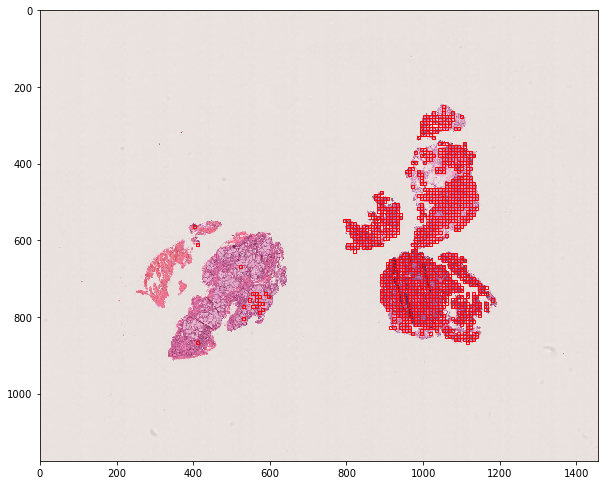

In [39]:
for ts in ts_list:
    ts.show_wsi_with_marked_tiles()

## Extract one tile directly from a WSI at a specific level

In [40]:
p = wsis_path.ls()[0];p

PosixPath('/home/Deep_Learner/shared/Datasets/Hypophysenadenome/wsis_experimenting/1422-10-IV-HE.ndpi')

In [41]:
s = slide.open_slide(p)

In [42]:
s.level_dimensions

((39424, 26880),
 (19712, 13440),
 (9856, 6720),
 (4928, 3360),
 (2464, 1680),
 (1232, 840),
 (616, 420),
 (308, 210),
 (154, 105))

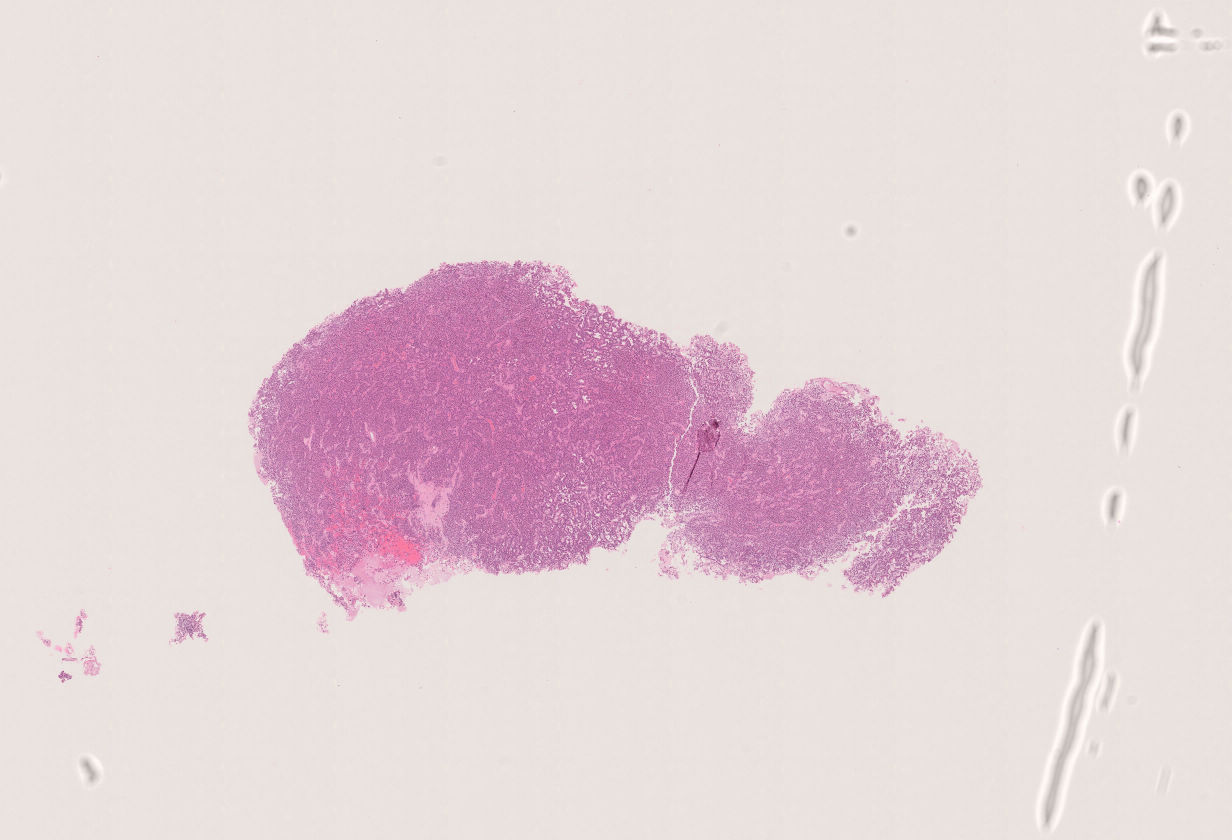

In [43]:
tiles.ExtractTileFromWSI(p, x=0,y=0, width=1232,height=840,level=5)

## ROIs polygonal

In [67]:
import json

PATH_DNETS = Path('/home/Deep_Learner/private/datasets/DNETs/')
wsi_path = PATH_DNETS/'N472-14.ndpi'
json_path = PATH_DNETS/'N472-14.json'

In [68]:
wsi = slide.open_slide(wsi_path)

In [69]:
wsi.level_dimensions

((35840, 53760),
 (17920, 26880),
 (8960, 13440),
 (4480, 6720),
 (2240, 3360),
 (1120, 1680),
 (560, 840),
 (280, 420),
 (140, 210),
 (70, 105))

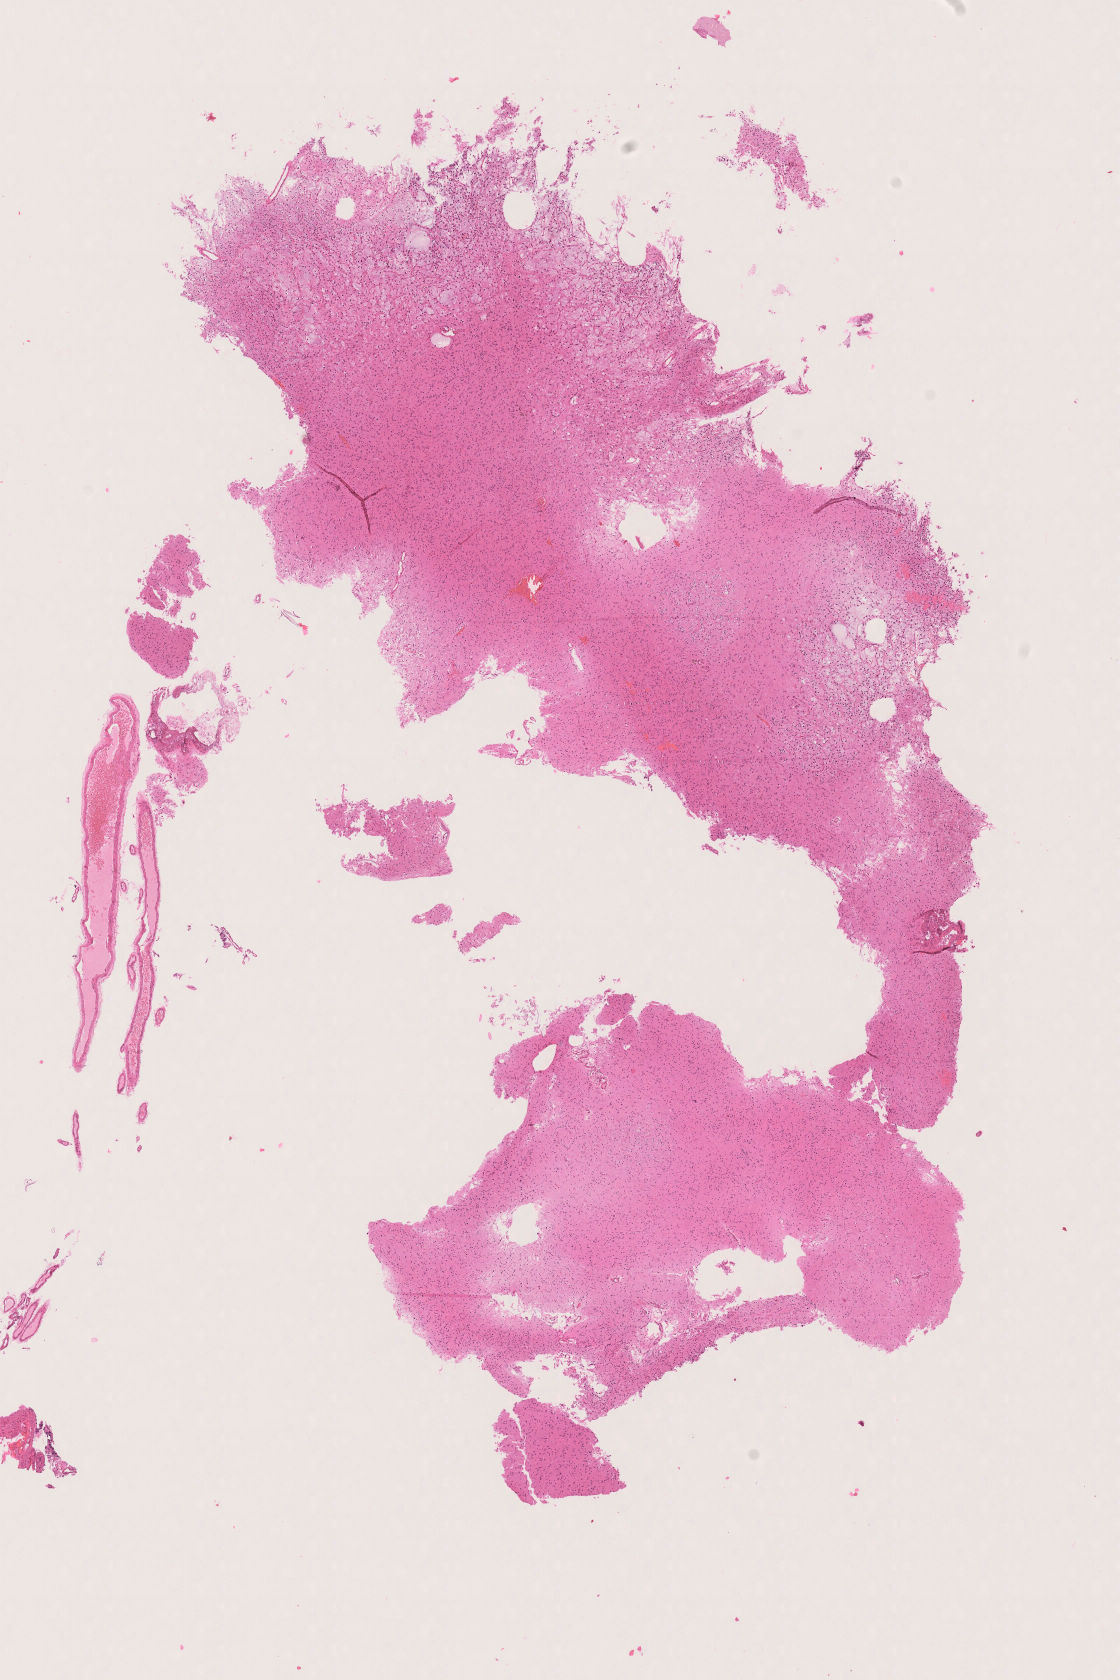

In [70]:
wsi_png = tiles.wsi_to_scaled_pil_image(wsi_filepath=wsi_path)[0];wsi_png

In [71]:
rois_poly = []
with open(json_path) as json_file:
    data = json.load(json_file)
    for n, polygon_coords in enumerate(data):
        coordinates = polygon_coords["geometry"]["coordinates"][0]
        coordinates = np.array(coordinates)
        roi = RegionOfInterestPolygon(roi_id=n, vertices=coordinates, level=0)
        rois_poly.append(roi)

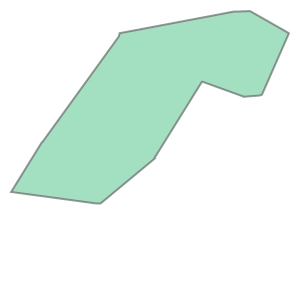

In [72]:
polygon = shapely.geometry.Polygon(coordinates); polygon

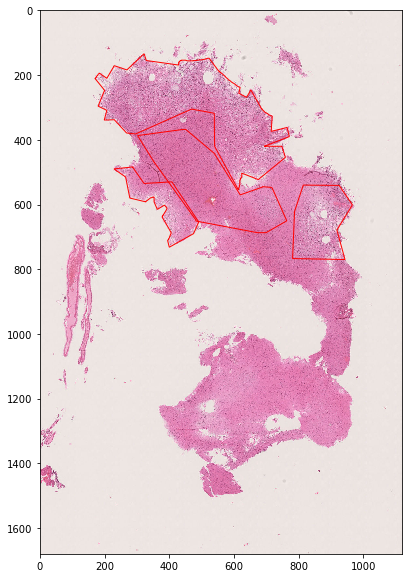

In [73]:
util.show_wsi_with_rois(wsi_path=wsi_path, rois = rois_poly)

In [74]:
tile_indices = tiles.get_tile_indices(rows=wsi.dimensions[1], 
                                      cols=wsi.dimensions[0], 
                                      row_tile_size=1024, 
                                      col_tile_size=1024)
tile_indices[:5]

[(0, 1024, 0, 1024, 1, 1),
 (0, 1024, 1024, 2048, 1, 2),
 (0, 1024, 2048, 3072, 1, 3),
 (0, 1024, 3072, 4096, 1, 4),
 (0, 1024, 4096, 5120, 1, 5)]

In [75]:
import shapely
tiles_as_polygons = []
tiles_as_rois = []
count = 0
for ti in tqdm(tile_indices):
    r_s, r_e, c_s, c_e, r, c = ti
    #x_upper_left = c_s
    #x_upper_right = c_e
    #x_lower_left = c_s
    #x_lower_right = c_e
    #y_upper_left = r_s
    #y_upper_right = r_s
    #y_lower_left = r_e
    #y_lower_right = r_e
    tile_poly = shapely.geometry.box(minx=c_s, miny=r_s, maxx=c_e, maxy=r_e)    
    tile_roi = RegionOfInterestPolygon(roi_id=count, vertices=util.polygon_to_numpy(tile_poly), level=0)
        
    #check if tile is in one of the rois
    if(tiles.is_tile_in_one_of_the_rois(rois=rois_poly, tile=tile_poly, minimal_tile_roi_intersection_ratio=0.7)):
        tiles_as_polygons.append(tile_poly)
        tiles_as_rois.append(tile_roi)

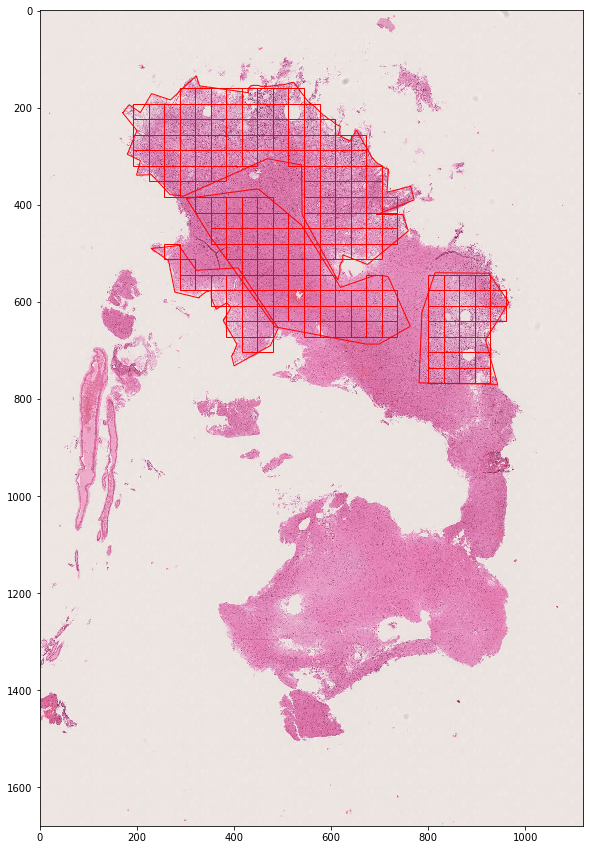

In [76]:
util.show_wsi_with_rois(wsi_path=wsi_path, rois=rois_poly + tiles_as_rois, figsize=(15,15))

In [82]:
ts = tiles.WsiOrROIToTiles(wsi_path=wsi_path, 
                           tiles_folder_path=None, 
                           tile_height=1024, 
                           tile_width=1024, 
                           minimal_acceptable_tile_height=0.7, 
                           minimal_acceptable_tile_width=0.7, 
                           tile_score_thresh=0.0,
                           tile_scoring_function=tiles.scoring_function_1,
                           level=0, 
                           save_tiles=False, 
                           rois=rois_poly, 
                           minimal_tile_roi_intersection_ratio=0.7)

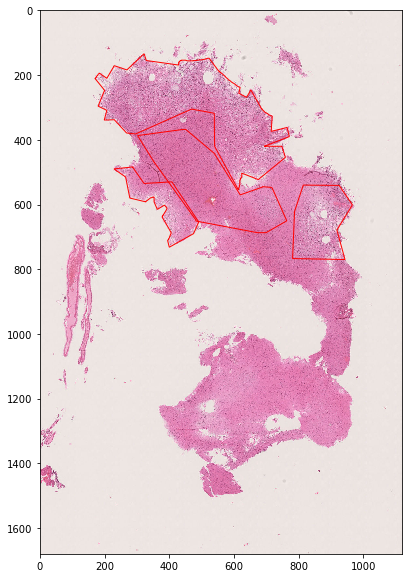

In [83]:
ts.show_wsi_with_rois()

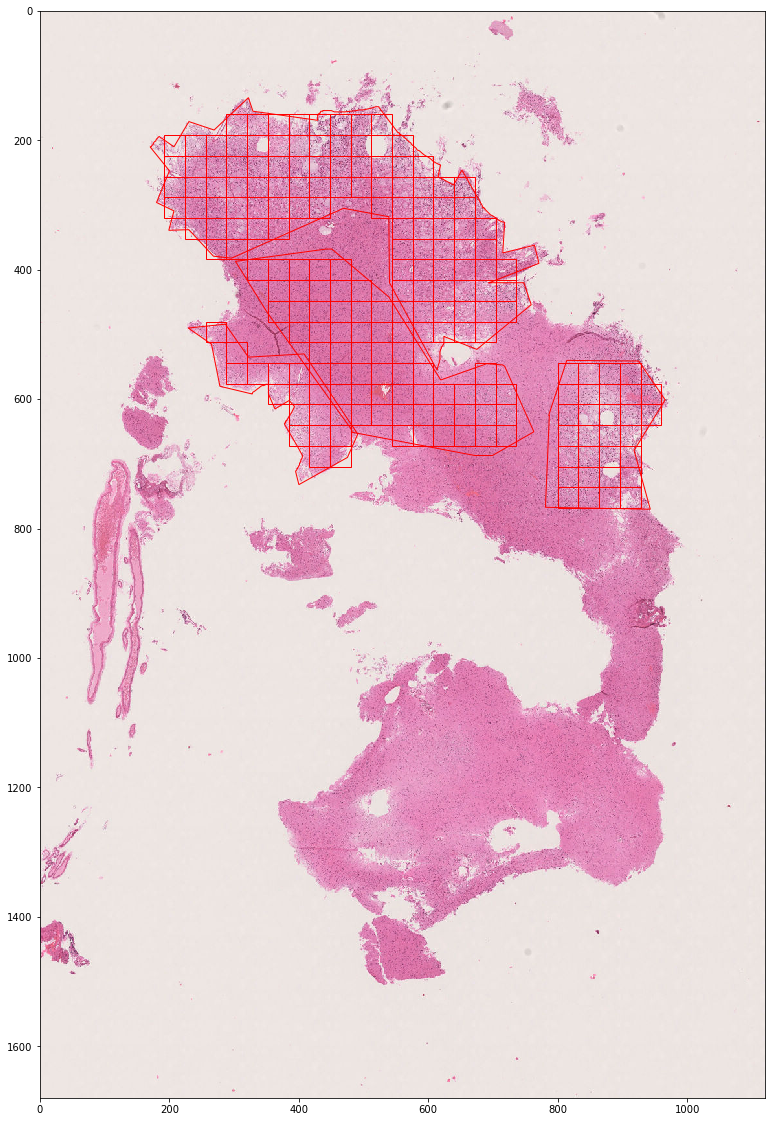

In [84]:
ts.show_wsi_with_top_tiles(figsize=(20,20))

In [85]:
#TODO other level than 0
ts = tiles.WsiOrROIToTiles(wsi_path=wsi_path, 
                           tiles_folder_path=None, 
                           tile_height=1024, 
                           tile_width=1024, 
                           minimal_acceptable_tile_height=0.7, 
                           minimal_acceptable_tile_width=0.7, 
                           tile_score_thresh=0.0,
                           tile_scoring_function=tiles.scoring_function_1,
                           level=1, 
                           save_tiles=False, 
                           rois=rois_poly, 
                           minimal_tile_roi_intersection_ratio=0.7)

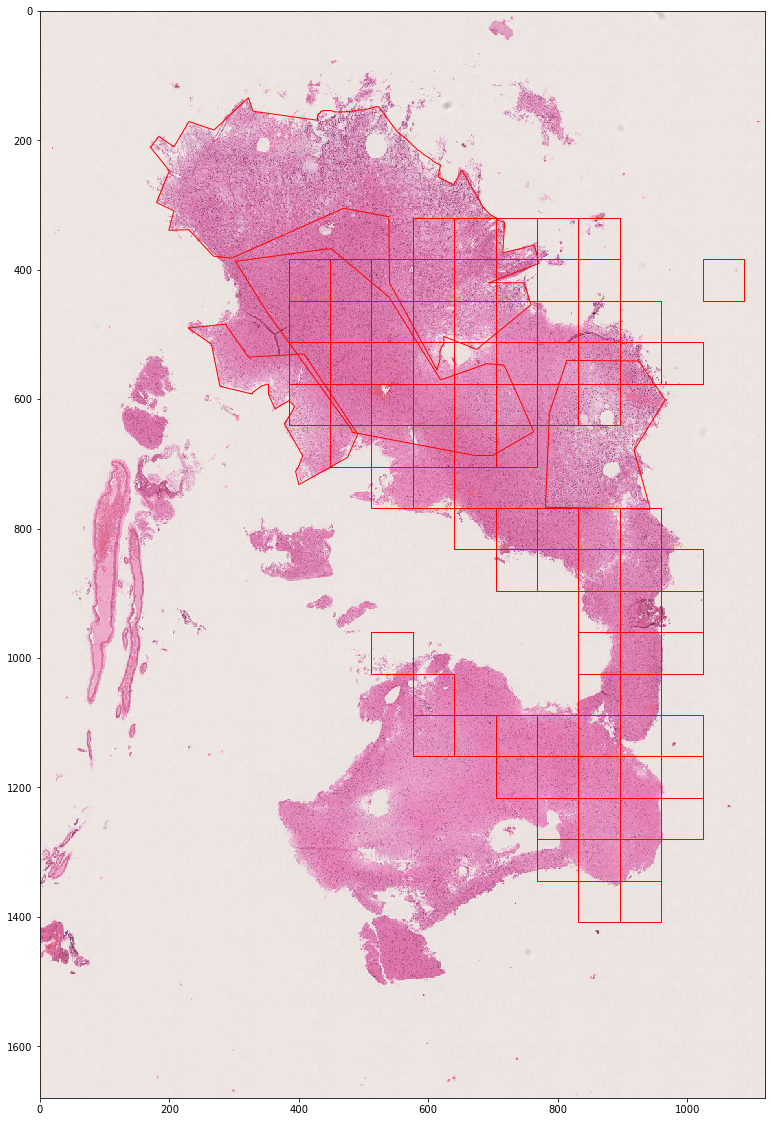

In [86]:
ts.show_wsi_with_top_tiles(figsize=(20,20))

# ROIs (rois that have already been extracted from a wsi and saved as .png for example)

## Process one ROI

In [46]:
from tile_extraction.tiles import *

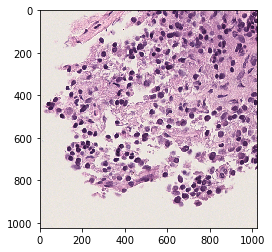

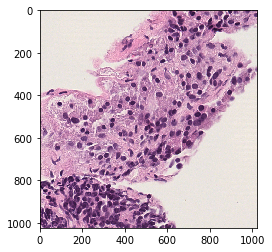

In [7]:
p = rois_path.ls()[0];p

tiles.WsiOrROIToTiles(wsi_path=p, 
                      tiles_folder_path=tiles_path, 
                      tile_height=1024,
                      tile_width=1024,  
                      tile_naming_func=tiles.get_roi_name_from_path_pituitary_adenoma_entities, 
                      save_tiles=True, 
                      return_as_tilesummary_object=False)

util.show_multiple_images_big(tiles_path.ls()[:2])

## Extract one tile directly from a ROI

(3089, 3089)


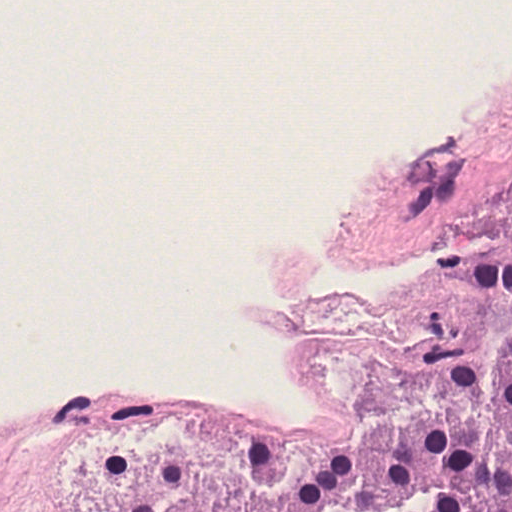

In [8]:
p = rois_path.ls()[0];p

img = PIL.Image.open(p)

print(img.size)

tiles.ExtractTileFromPILImage(p, 1000, 1000, 512, 512)